# Implement Online portfolio algorithms directly into the Gyn environment

In [60]:
import numpy as np
import pandas as pd

from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback
from typing import Any, ClassVar, Dict, Iterable, List, Optional, Tuple, Type, TypeVar, Union


class BAHModel:
    def __init__(
            self, 
            env: Union[GymEnv, str],
            policy: Any, # Policy doesnt matter here
            device: str, # device doesnt matter here
            policy_kwargs: Optional[Dict[str, Any]] = None, # policy_kwargs doesnt matter here
            target_weights: List[float] = None # If none, default to uniform weights
            ) -> None:
        
        # Super simple algorithm, we only need the environment
        # This environment needs to have prices for the BAH algorithm TODO check the type here

        assert env is not None 
        self.env = env

        # Pull out the actions space dimensions for the portfolio
        self.action_space_shape = self.env.action_space.shape
        self.portfolio_length = self.action_space_shape[0]

        # Calculate the inital weights, (defualt to uniform)
        # Uniform base case
        # Note these are the first weight reprsents the cash account, which should always be 0
        self.target_weights = np.ones(self.portfolio_length-1) / (self.portfolio_length-1)  # target weights for each asset
        # Append 0 to the beginning, for an empty cash account
        self.target_weights = np.insert(self.target_weights, 0, 0)

        print(self.target_weights)
        
        if target_weights is not None:
            # Assert that the portfolio length matches (index 0 represents cash account)
            assert len(target_weights) == self.portfolio_length
            self.target_weights = np.array(target_weights)

    def train(self) -> None:
        # TODO this model is derministic and doesnt learn anything, it only predicts
        pass

    def learn(
        self
    ):
        # TODO this model is derministic and doesnt learn anything, it only predicts
        pass

    def predict(
        self,
        observation: Union[np.ndarray, Dict[str, np.ndarray]],
        state: Optional[Tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False, # TODO not needed this is always determininistic
    ) -> Tuple[np.ndarray, Optional[Tuple[np.ndarray, ...]]]:

        # TODO much of this comes from the policies class in stable baselines
        if isinstance(observation, tuple) and len(observation) == 2 and isinstance(observation[1], dict):
            raise ValueError(
                "You have passed a tuple to the predict() function instead of a Numpy array or a Dict. "
                "You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) "
                "vs `obs = vec_env.reset()` (SB3 VecEnv). "
                "See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 "
                "and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api"
            )
        
        # For BAH we just use whatever weights are already in the environment.

        # For the first step we need to do the initial buy, after that we just let the portfolio run

        # If we are on first time-step, buy the portfolio
        actions = self.target_weights.reshape(1, self.portfolio_length)

        # else 
        if len(self.env._actions_memory) > 1:
            # Use the last portfolio as the new action (keep it the same)
            actions = self.env._final_weights[-1].reshape(1, self.portfolio_length)

        # The state doesnt matter here
        return actions, None

In [61]:


MODELS = {"bah": BAHModel}

class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        # TODO default to usethe MlpPolicy
        return model(env=self.env, policy="MlpPolicy", **model_kwargs)

    @staticmethod
    def train_model(model, env, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        model.learn(
            total_timesteps = max_steps * episodes # TODO fix this
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        

        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
            action, _states = model.predict(test_obs, deterministic=deterministic)
            # print("HERE!!!!!!!")
            # print(action)
            # print(type(action))

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates

In [62]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2020-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-01-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER


# TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()


from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)
portfolio_norm_df

df_train = portfolio_norm_df[(portfolio_norm_df["date"] >= TRAIN_START_DATE) & (portfolio_norm_df["date"] <= TRAIN_END_DATE)]
df_2021 = portfolio_norm_df[(portfolio_norm_df["date"] >= TEST_START_DATE) & (portfolio_norm_df["date"] <= "2021-12-31")]
df_2022 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2022-01-01") & (portfolio_norm_df["date"] <= "2022-12-31")]
df_2023 = portfolio_norm_df[(portfolio_norm_df["date"] >= "2023-01-01") & (portfolio_norm_df["date"] < TEST_END_DATE)]

from finrl.meta.env_portfolio_optimization.env_portfolio_opt_stable import PortfolioOptStableEnv

environment = PortfolioOptStableEnv(
        df_train,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

BAH_results = {
    "date": {},
    "training": {},
    "2021": {},
    "2022": {},
    "2023": {}
}


environment_2021 = PortfolioOptStableEnv(
    df_2021,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


environment_2022 = PortfolioOptStableEnv(
    df_2022,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

environment_2023 = PortfolioOptStableEnv(
    df_2023,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)


# Training
agent_bah = DRLStableAgent(env = environment)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment)
BAH_results["training"] = environment._terminal_asset_memory["final"]
BAH_results["date"] = environment._terminal_date_memory

# 2021
agent_bah = DRLStableAgent(env = environment_2021)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_2021)
BAH_results["2021"]["value"] = environment_2021._terminal_asset_memory["final"]
BAH_results["2021"]["date"] = environment_2021._terminal_date_memory


# 2022
agent_bah = DRLStableAgent(env = environment_2022)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_2022)
BAH_results["2022"]["value"] = environment_2022._terminal_asset_memory["final"]
BAH_results["2022"]["date"] = environment_2022._terminal_date_memory

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (107677, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.31332941 0.43188074 0.33824661 ... 0.02556499 0.01810204 0.02266286]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5  0.75 1.   ... 0.5  0.75 1.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(


[0.         0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276]


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 9091124.0
Final accumulative portfolio value: 9.091124
Maximum DrawDown: -0.3434854214236923
Sharpe ratio: 1.119970666324929
Total commission cost: 0.0
hit end!
[0.         0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276]


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1209208.25
Final accumulative portfolio value: 1.20920825
Maximum DrawDown: -0.06421684228201308
Sharpe ratio: 1.6322807116204705
Total commission cost: 0.0
hit end!
[0.         0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276]


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 932273.0625
Final accumulative portfolio value: 0.9322730625
Maximum DrawDown: -0.21091719587900137
Sharpe ratio: -0.27762959015451033
Total commission cost: 0.0
hit end!


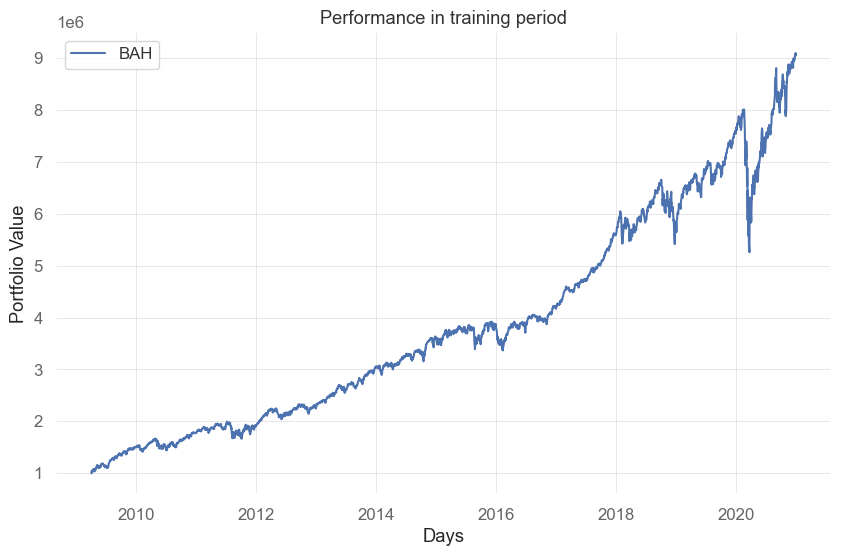

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(BAH_results["date"], BAH_results["training"], label="BAH")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

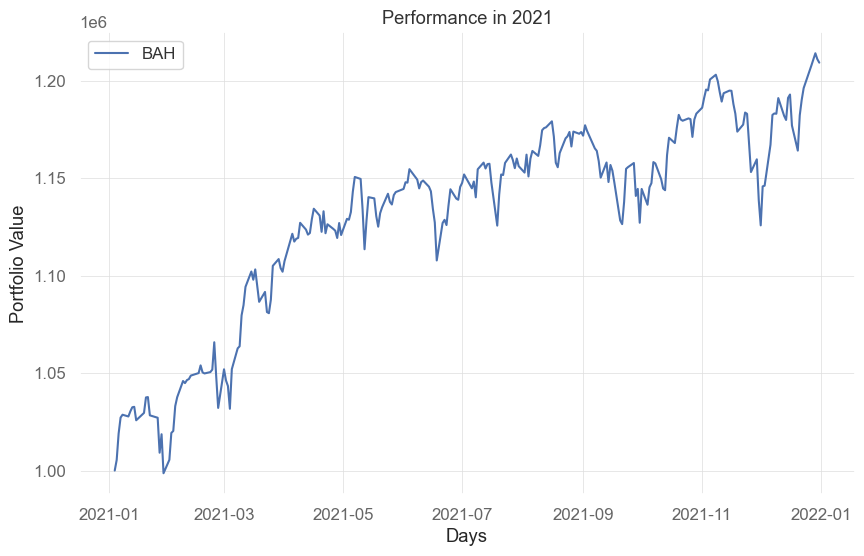

In [64]:
plt.plot(BAH_results["2021"]["date"], BAH_results["2021"]["value"], label="BAH")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2021")
plt.legend()

plt.show()

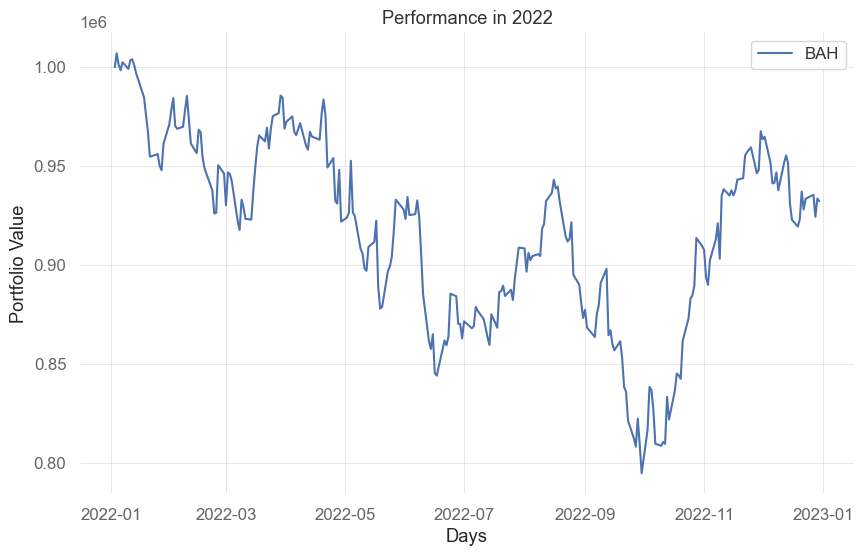

In [65]:
plt.plot(BAH_results["2022"]["date"], BAH_results["2022"]["value"], label="BAH")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in 2022")
plt.legend()

plt.show()